In [1]:
import tuxml
import pandas as pd 

df = tuxml.load_dataset()
df.replace(2, 0, inplace=True)

In [2]:
df.sort_values("vmlinux")[:5]

,X86_LOCAL_APIC,OPENVSWITCH,TEXTSEARCH_FSM,LOCKDEP_SUPPORT,GENERIC_CLOCKEVENTS_MIN_ADJUST,NETFILTER_XT_MATCH_TCPMSS,MPLS,NFC_HCI,STACKTRACE_SUPPORT,GENERIC_CMOS_UPDATE,...,LZO-vmlinux,LZO,LZ4-bzImage,LZ4-vmlinux,LZ4,cid,nbyes,nbno,nbmodule,nbyesmodule
109097,1,0,0,1,1,0,0,0,1,1,...,2863640,644621,814544.0,2900824,669288,124978,241,12237,0,241
58621,1,0,0,1,1,0,0,0,1,1,...,2777624,558712,724432.0,2810712,578375,74458,240,12238,0,240
107213,1,0,0,1,1,0,0,0,1,1,...,3953176,1734208,1986512.0,4072280,1841339,123091,741,11068,669,1410
99232,1,0,0,1,1,0,0,0,1,1,...,4248440,2027905,2290640.0,4375728,2144007,115110,636,11131,711,1347
99777,1,0,0,1,1,0,0,0,1,1,...,4096536,1877790,2139088.0,4223832,1994471,115655,721,11351,406,1127


In [3]:
size_methods = ["vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "GZIP", "BZIP2-bzImage", 
              "BZIP2-vmlinux", "BZIP2", "LZMA-bzImage", "LZMA-vmlinux", "LZMA", "XZ-bzImage", "XZ-vmlinux", "XZ", 
              "LZO-bzImage", "LZO-vmlinux", "LZO", "LZ4-bzImage", "LZ4-vmlinux", "LZ4"]

In [4]:
additional_ft = ["nbyes", "nbno", "nbmodule", "nbyesmodule"]

In [5]:
#learning a model by using linear regression
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import ElasticNet

def run_regressorML(reg, test_size, size_target, x_train, x_test):
    assert(size_target in size_methods)
    reg.fit(x_train, y_train)
    y_pred = reg.predict(x_test)
    #y_pred = reg.intercept_ + np.sum(reg.coef_ * x_test.values, axis=1)
    dfErrors = pd.DataFrame({"error":(y_pred - y_test).abs(), "% error":((y_pred - y_test)/y_test).abs()*100})
    return dfErrors["% error"].mean() #.describe()

In [6]:
def ft_importances(coef_, col):
    importanceSeries = pd.Series(coef_, index=col)
    return importanceSeries[importanceSeries != 0].abs().sort_values(ascending = False) #.abs()

In [7]:
df_result = pd.DataFrame(columns = ['algorithm_name', 'origin_ft_selection', 'ft_selection', 'num_options', 'hyperparameters', 'size_target', 'additional_ft', 'test_size', 'coef_order', 'accuracy'])

In [8]:
def select_ft(alg, num_options):
    if (alg=="RandomForest"):
        res = pd.read_csv("feature_importanceRF.csv", header=None)
        res.rename(columns={0 : 'option', 1 : 'importance'}, inplace=True)
        res.query('option != "nbyes" and option !="nbyesmodule" and option != "nbno" and option != "nbmodule"', inplace = True)  
    else:
        res = pd.read_csv("coef_"+alg+"_None_90_12498.csv", header=None)
        res.rename(columns={0 : 'option', 1 : 'importance'}, inplace=True)
        res = res.iloc[1:]
    return res["option"].values[:num_options] 

In [9]:
def drop_ft(drop_features):
    if not drop_features:
        return additional_ft
    else:
        df.drop(columns=drop_features, inplace=True) 
        return [value for value in additional_ft if value not in drop_features]

In [10]:
def save_coeffs(coef_order, key, origin_ft_selection, size, num_options):
    name_coef_file = "coef_"+key+"_"+origin_ft_selection+"_"+str(round(size*100))+"_"+str(num_options)+".csv"
    df_coef = pd.DataFrame(coef_order) 
    df_coef.to_csv(name_coef_file, header=True)
    return name_coef_file

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn import linear_model
from sklearn import metrics

target = "vmlinux"
additional_ft = drop_ft(additional_ft) 

for num_options in [df.columns.size,50,100,150,200,250,300,350,400,450,500]:
    
    if (num_options==df.columns.size):
        #original dataset without additional_ft
        ft_selection = {'None': df.drop(columns=["cid"]).drop(columns=size_methods).columns,}
    else:
        ft_selection = {'RandomForest': select_ft('RandomForest', num_options),
                        'LinearRegression': select_ft('LinearRegression', num_options),
                        'LassoCV': select_ft('LassoCV', num_options),
                        'RidgeCV': select_ft('RidgeCV', num_options),
                        'ElasticNetCV': select_ft('ElasticNetCV', num_options),}
        
    for origin_ft_selection in ft_selection:
        for size in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
            x_train, x_test, y_train, y_test = train_test_split(df[ft_selection[origin_ft_selection]], df[target], test_size=size, random_state=42)  

            model = {'LinearRegression': LinearRegression(),
                     'LassoCV': linear_model.LassoCV(cv=2, n_jobs=-1).fit(x_train, y_train),               
                     'RidgeCV': linear_model.RidgeCV(cv=2).fit(x_train, y_train),  
                     'ElasticNetCV': linear_model.ElasticNetCV(cv=2, n_jobs=-1).fit(x_train, y_train),
                     'PolynomialRegression': LinearRegression()}
        
            for key in model:
                if (key == 'PolynomialRegression') and (origin_ft_selection == 'None'):
                    print("It doesn't scale")
                else:
                    if (key == 'PolynomialRegression'):
                        pf = PolynomialFeatures(degree=2, include_bias=False)
                        x_train_pf = pf.fit_transform(x_train)
                        x_test_pf = pf.fit_transform(x_test)
                        res_model = run_regressorML(model[key], test_size=size, size_target=target, x_train=x_train_pf, x_test=x_test_pf)
                        importanceSeries = pd.Series(model[key].coef_, index=pf.get_feature_names(x_train.columns))
                        coef_order = importanceSeries[importanceSeries != 0].abs().sort_values(ascending = False)
                    else:
                        res_model = run_regressorML(model[key], test_size=size, size_target=target, x_train=x_train, x_test=x_test)
                        coef_order = ft_importances(model[key].coef_, col=ft_selection[origin_ft_selection])
                        
                    name_coef_file = save_coeffs(coef_order, key, origin_ft_selection, size, num_options)
                           
                    df_result.loc[len(df_result)] = [key, origin_ft_selection, ft_selection[origin_ft_selection], df[ft_selection[origin_ft_selection]].columns.size, model[key], target, additional_ft, size, name_coef_file, res_model]
                    df_result.to_csv("results.csv", header=True)

In [12]:
res = pd.read_csv('results.csv')
res

,Unnamed: 0,algorithm_name,origin_ft_selection,ft_selection,num_options,hyperparameters,size_target,additional_ft,test_size,coef_order,accuracy
0,0,LinearRegression,None,"Index(['X86_LOCAL_APIC', 'OPENVSWITCH', 'TEXTS...",12478,"LinearRegression(copy_X=True, fit_intercept=Tr...",vmlinux,[],0.98,coef_LinearRegression_None_98_12498.csv,1.106718e+02
1,1,LassoCV,None,"Index(['X86_LOCAL_APIC', 'OPENVSWITCH', 'TEXTS...",12478,"LassoCV(alphas=None, copy_X=True, cv=2, eps=0....",vmlinux,[],0.98,coef_LassoCV_None_98_12498.csv,3.557823e+01
2,2,RidgeCV,None,"Index(['X86_LOCAL_APIC', 'OPENVSWITCH', 'TEXTS...",12478,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=2...",vmlinux,[],0.98,coef_RidgeCV_None_98_12498.csv,1.079970e+02
3,3,ElasticNetCV,None,"Index(['X86_LOCAL_APIC', 'OPENVSWITCH', 'TEXTS...",12478,"ElasticNetCV(alphas=None, copy_X=True, cv=2, e...",vmlinux,[],0.98,coef_ElasticNetCV_None_98_12498.csv,8.300406e+01
4,4,LinearRegression,RandomForest,['DEBUG_INFO' 'DEBUG_INFO_REDUCED' 'DEBUG_INFO...,50,"LinearRegression(copy_X=True, fit_intercept=Tr...",vmlinux,[],0.98,coef_LinearRegression_RandomForest_98_50.csv,4.046627e+01
5,5,LassoCV,RandomForest,['DEBUG_INFO' 'DEBUG_INFO_REDUCED' 'DEBUG_INFO...,50,"LassoCV(alphas=None, copy_X=True, cv=2, eps=0....",vmlinux,[],0.98,coef_LassoCV_RandomForest_98_50.csv,3.766915e+01
6,6,RidgeCV,RandomForest,['DEBUG_INFO' 'DEBUG_INFO_REDUCED' 'DEBUG_INFO...,50,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=2...",vmlinux,[],0.98,coef_RidgeCV_RandomForest_98_50.csv,4.024037e+01
7,7,ElasticNetCV,RandomForest,['DEBUG_INFO' 'DEBUG_INFO_REDUCED' 'DEBUG_INFO...,50,"ElasticNetCV(alphas=None, copy_X=True, cv=2, e...",vmlinux,[],0.98,coef_ElasticNetCV_RandomForest_98_50.csv,8.311615e+01
8,8,PolynomialRegression,RandomForest,['DEBUG_INFO' 'DEBUG_INFO_REDUCED' 'DEBUG_INFO...,50,"LinearRegression(copy_X=True, fit_intercept=Tr...",vmlinux,[],0.98,coef_PolynomialRegression_RandomForest_98_50.csv,9.609469e+11
9,9,LinearRegression,LinearRegression,['DEBUG_INFO' 'UBSAN_SANITIZE_ALL' 'GCOV_PROFI...,50,"LinearRegression(copy_X=True, fit_intercept=Tr...",vmlinux,[],0.98,coef_LinearRegression_LinearRegression_98_50.csv,5.586036e+01


In [40]:
res1 = res.query("origin_ft_selection == 'RandomForest' and algorithm_name == 'LinearRegression'")
res2 = res.query("origin_ft_selection == 'RandomForest' and algorithm_name == 'LassoCV'")
res3 = res.query("origin_ft_selection == 'RandomForest' and algorithm_name == 'RidgeCV'")
res4 = res.query("origin_ft_selection == 'RandomForest' and algorithm_name == 'ElasticNetCV'")

No handles with labels found to put in legend.


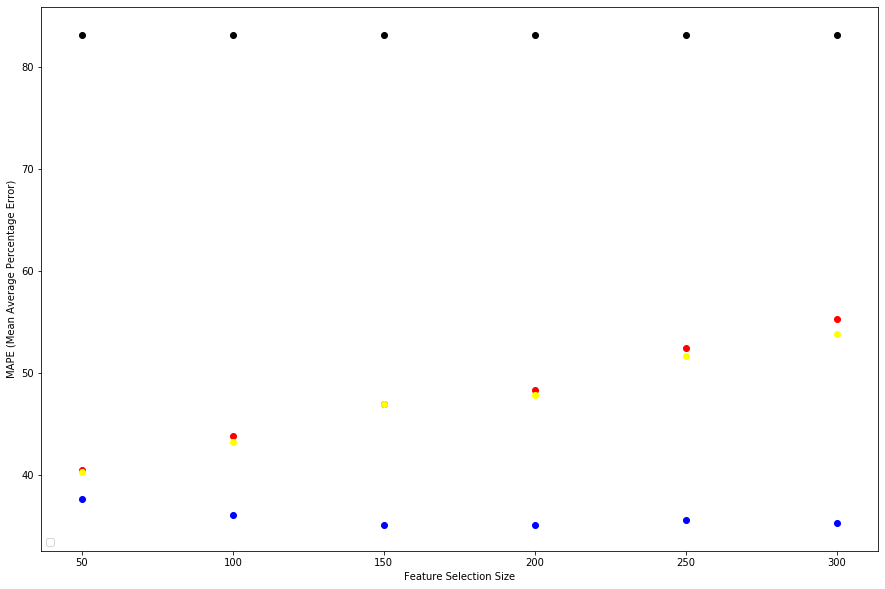

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize =(15,10))

for index, row in res1.iterrows():
    plt.scatter(row["num_options"], row["accuracy"], color="red")
for index, row in res2.iterrows():
    plt.scatter(row["num_options"], row["accuracy"], color="blue")
for index, row in res3.iterrows():
    plt.scatter(row["num_options"], row["accuracy"], color="yellow")
for index, row in res4.iterrows():
    plt.scatter(row["num_options"], row["accuracy"], color="black")
    
#plt.scatter(res["size_target"], res["accuracy"], label=res['name'])
plt.legend(scatterpoints=1, loc='lower left', fontsize=10)
plt.xlabel("Feature Selection Size")
plt.ylabel("MAPE (Mean Average Percentage Error)")
plt.savefig("lr_training_size.png")
plt.show()